In [23]:
!pip install timm einops
!wget https://github.com/Dao-AILab/flash-attention/releases/download/v2.6.3/flash_attn-2.6.3+cu123torch2.4cxx11abiFALSE-cp310-cp310-linux_x86_64.whl
!pip install --no-dependencies --upgrade flash_attn-2.6.3+cu123torch2.4cxx11abiFALSE-cp310-cp310-linux_x86_64.whl


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: flash_attn-2.6.3+cu123torch2.4cxx11abiFALSE-cp310-cp310-linux_x86_64.whl is not a supported wheel on this platform.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: flash_attn-2.6.3+cu123torch2.4cxx11abiFALSE-cp310-cp310-linux_x86_64.whl is not a supported wheel on this platform.


In [24]:
pip install transformers==4.37.2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# Ensure accelerate is properly installed
!pip install --upgrade accelerate
print("\n⚠️ Please restart your kernel after installation to use the accelerate library properly!")


⚠️ Please restart your kernel after installation to use the accelerate library properly!



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Important: Restart Kernel

After installing the dependencies above, please restart the kernel before continuing.

You can restart by clicking on the "Kernel" menu and selecting "Restart" or by pressing the restart button in your notebook interface.

In [27]:
import os
import numpy as np
import torch
import torchvision.transforms as T
# from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

# Check if accelerate is properly installed
try:
    import accelerate
    print("Accelerate version:", accelerate.__version__)
    has_accelerate = True
except ImportError:
    print("Warning: Accelerate not found. Will use fallback loading method.")
    has_accelerate = False

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

Accelerate version: 1.6.0


In [28]:
model_name = "5CD-AI/Vintern-1B-v2"
model_name = "5CD-AI/Vintern-1B-v3_5"

In [29]:
# Updated model loading with proper error handling and CPU/GPU fallback
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
try:
    # Try with accelerate features if available and CUDA
    model = AutoModel.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
        low_cpu_mem_usage=torch.cuda.is_available(),
        trust_remote_code=True,
        use_flash_attn=False,
    ).eval().to(device)
    print(f"Model loaded on {device} with accelerate features")
except ImportError as e:
    print(f"ImportError: {e}")
    print("Falling back to standard loading without accelerate features...")
    model = AutoModel.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
        trust_remote_code=True
    ).eval().to(device)
    print(f"Model loaded on {device} without accelerate features")
except Exception as e:
    print(f"Unexpected error: {e}")
    # Final fallback with minimal options
    model = AutoModel.from_pretrained(
        model_name,
        trust_remote_code=True
    ).eval().to(device)
    print(f"Model loaded on {device} with minimal options")

Model loaded on cuda with accelerate features


In [30]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [31]:
import matplotlib.pyplot as plt
import glob

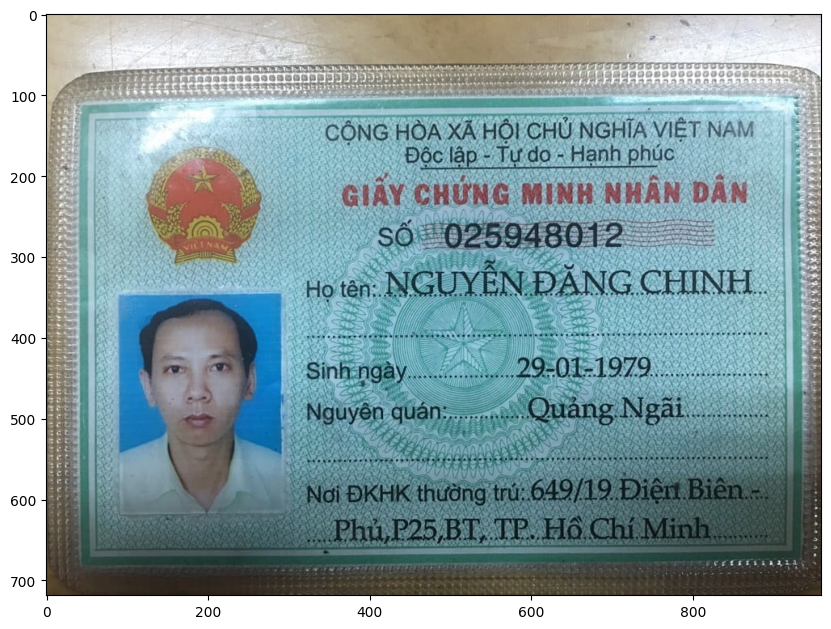

Token indices sequence length is longer than the specified maximum sequence length for this model (1868 > 1700). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Mô tả hình ảnh một cách chi tiết trả về dạng markdown.
Assistant: # Giấy Chứng Minh Nhân Dân

**Thông tin cá nhân:**

* **Họ tên:** NGUYỄN ĐĂNG CHÍNH
* **Ngày sinh:** 29-01-1979
* **Quê quán:** Quảng Ngãi
* **Nơi đăng ký hộ khẩu thường trú:** 649/19 Điện Biên - Phủ, P25, BT, TP. Hồ Chí Minh

**Thông tin giấy tờ:**

* **Số giấy tờ:** 025948012
* **Cộng hòa xã hội chủ nghĩa Việt Nam**
* **Độc lập - Tự do - Hạnh phúc**

**Hình ảnh:**

* Có ảnh chân dung của người sở hữu giấy tờ.


In [32]:
test_image = "C:/Users/minhh/Downloads/test.jpg"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.figure(figsize=(10,10))
plt.imshow(Image.open(test_image))
plt.show()
pixel_values = load_image(test_image, max_num=10).to(device, dtype=model.dtype)
generation_config = dict(max_new_tokens= 2024, do_sample=False, num_beams = 3, repetition_penalty=3.5)

question = '<image>\nMô tả hình ảnh một cách chi tiết trả về dạng markdown.'

response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

**Thời gian:** 29/12/2021 06:42 PM - 10:34 PM
**Nhân viên:** Thanh Ngân
**Hotline:** 19006096

| Tên món | Số lượng | Đơn giá (VNĐ) | Thành tiền (VNĐ) |
|---|---|---|---| 
| Bò WARNING | 2 | 215.000 | 430.000 |
| Tôm sống WARNING | 2 | 155.000 | 310.000 |
| Lòng Gà & Trứng Non Cháy | 2 | 180.000 | 360.000 |
| Tỏi | 2 | 180.000 | 360.000 |
| Lườn Ngỗng Xông Khói | 2 | 180.000 | 360.000 |
| Dậu Hủ Khói Lửa | 2 | 155.000 | 310.000 |
| Cơm Chiên Dưa Bò | 2 | 110.000 | 220.000 |
| Cơm Cháy Sốt Bò Mỹ | 2 | 18.000 | 36.000 |
| 7UP | 2 | 180.000 | 380.000 |
| ThápBia13-GHÉT Ô NHIỄM | 1 | 100.000 | 100.000 |
| Trái cây | 10 | 60.000 | 600.000 |
| SOFT DRINK | 10 | 27.000 | 243.000 |
| Ken Bạc | 9 | 27.000 | 243.000 |
| Khăn Lạnh | 10 | 3.000 | 30.000 |
| ThápBia13-QUÁ TẢI | 4 | 380.000 | 1.520.000 |

**Tổng cộng:** 5.659.000 VNĐ
**VAT:** 396.130 VNĐ
**Tiền thẻ:** 6.055.130 VNĐ